In [1]:
import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from utils import get_backend_properties_v1
from mlp import MLP1, MLP2, MLP3, encode_data

import matplotlib.pyplot as plt
import seaborn as sns
from noise_utils import AddNoise, RemoveReadoutErrors
from mlp import recursive_dict_loop, count_gates_by_rotation_angle
from mbd_utils import calc_imbalance
import torch
from torch import nn
from sklearn import datasets
import sklearn
from utils import circuit_to_graph_data_json
from utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
)
from qiskit.circuit.random import random_circuit
from sklearn.model_selection import train_test_split
from qiskit.converters import circuit_to_dag
from scripts.data_setup import load_data
from scripts.gate_dict_script import gate_dict_method
from scripts.from_circ_to_numpy import operations_to_features
from tqdm.auto import tqdm

In [2]:
backend = FakeLima()
n_qubits = 5

In [3]:
train_circuits, train_observables, train_ideal_exp_vals, train_noisy_exp_vals, test_circuits, test_observables, test_ideal_exp_vals, test_noisy_exp_vals = load_data('data/circuits/data_small_1')

In [4]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [5]:
properties = get_backend_properties_v1(backend=backend)

In [6]:
def encode_data(circuits, properties, ideal_exp_vals, noisy_exp_vals, num_qubits, meas_bases=None):
    # if isinstance(noisy_exp_vals[0], list) and len(noisy_exp_vals[0]) == 1:
    #     noisy_exp_vals = [x[0] for x in noisy_exp_vals]

    gates_set = sorted(properties['gates_set'])     # must sort!

    if meas_bases is None:
        meas_bases = [[]]

    vec = [np.mean(recursive_dict_loop(properties, out=[], target_key1='cx', target_key2='gate_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='id', target_key2='gate_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='sx', target_key2='gate_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='x', target_key2='gate_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='rz', target_key2='gate_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='', target_key2='readout_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='', target_key2='t1'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='', target_key2='t2'))]
    vec = torch.tensor(vec) * 100  # put it in the same order of magnitude as the expectation values

    bin_size = 0.1 * np.pi
    num_angle_bins = int(np.ceil(4 * np.pi / bin_size))

    X = torch.zeros([len(circuits), len(vec) + len(gates_set) + num_angle_bins + num_qubits + len(meas_bases[0])])

    vec_slice = slice(0, len(vec))
    gate_counts_slice = slice(len(vec), len(vec)+len(gates_set))
    angle_bins_slice = slice(len(vec)+len(gates_set), len(vec)+len(gates_set)+num_angle_bins)
    exp_val_slice = slice(len(vec)+len(gates_set)+num_angle_bins, len(vec)+len(gates_set)+num_angle_bins+num_qubits)
    meas_basis_slice = slice(len(vec)+len(gates_set)+num_angle_bins+num_qubits, len(X[0]))

    X[:, vec_slice] = vec[None, :]

    for i, circ in enumerate(circuits):
        gate_counts_all = circ.count_ops()
        X[i, gate_counts_slice] = torch.tensor(
            [gate_counts_all.get(key, 0) for key in gates_set]
        ) * 0.01  # put it in the same order of magnitude as the expectation values

    for i, circ in enumerate(circuits):
        gate_counts = count_gates_by_rotation_angle(circ, bin_size)
        X[i, angle_bins_slice] = torch.tensor(gate_counts) * 0.01  # put it in the same order of magnitude as the expectation values

        # if num_qubits > 1: assert len(noisy_exp_vals[i]) == num_qubits
        # elif num_qubits == 1: assert isinstance(noisy_exp_vals[i], float)

        X[i, exp_val_slice] = torch.tensor(noisy_exp_vals[i])

    if meas_bases != [[]]:
        assert len(meas_bases) == len(circuits)
        for i, basis in enumerate(meas_bases):
            X[i, meas_basis_slice] = torch.tensor(basis)

    y = torch.tensor(ideal_exp_vals, dtype=torch.float32)

    return X, y


In [7]:
X_train_rf, y_train_rf = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals, num_qubits=n_qubits)
X_test_rf, y_test_rf = encode_data(test_circuits, properties, test_ideal_exp_vals, test_noisy_exp_vals, num_qubits=n_qubits)
BATCH_SIZE = 32
fix_random_seed(42)
train_dataset = TensorDataset(torch.Tensor(X_train_rf), torch.Tensor(y_train_rf))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test_rf), torch.Tensor(y_test_rf))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

random seed fixed to 42


In [8]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rfr = RandomForestRegressor(n_estimators=300)
rfr.fit(X_train_rf, y_train_rf)

RandomForestRegressor(n_estimators=300)

In [9]:
from sklearn.metrics import root_mean_squared_error

In [10]:
y_pred_rf = rfr.predict(X_test_rf)
rms = root_mean_squared_error(y_test_rf, y_pred_rf)

In [11]:
rms

0.21440823527288264

In [12]:
circuit_depths = []
for circuit in test_circuits:
    circuit_depths.append(transpile(circuit, optimization_level=0, backend=backend).depth())

In [37]:
mse_list = []
for i in range(len(y_pred_rf)):
    mse_list.append((y_pred_rf[i] - test_ideal_exp_vals[i])**2)

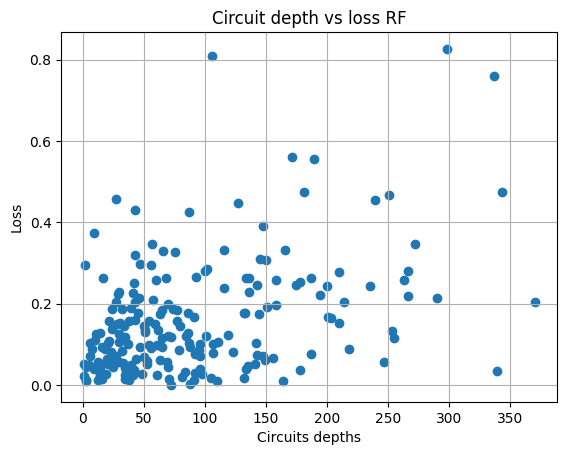

In [39]:
plt.scatter(circuit_depths, np.sqrt(mse_list))
plt.xlabel('Circuits depths')
plt.ylabel('Loss')
plt.title('Circuit depth vs loss RF')
plt.grid(True)
plt.show()